In [1]:
import numpy as np
import matplotlib.dates as dts
import pandas as pd
import statsmodels.api as sm
from bs4 import BeautifulSoup
import subprocess,os
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'

In [2]:
# -1.0 Create an svg map using the simplemapplot package

# If the map file usMap.svg is not available locally uncomment the following.
# Note that simplemapplot is not compatible with python 3.

# import simplemapplot
# simplemapplot.make_us_state_map({"GA":0},colors=['#7FA9CF'],output_img='usMap.svg')
svg = open('../svg/usMap.svg', 'r').read()

In [3]:
# 0. Setup

# 0.1 general plot settings

# font = {'weight' : 'bold',
#         'size'   : 15}
# plt.rc('font', **font)
# plt.rcParams['xtick.major.pad']='8'
# plt.rcParams['ytick.major.pad']='8'


# 0.2 Formatter for inserting commas in y axis labels with magnitudes in the thousands

def func(x, pos):  # formatter function takes tick label and tick position
   s = '{:0,d}'.format(int(x))
   return s

y_format = plt.FuncFormatter(func)  # make formatter

# 0.3 format the x axis ticksticks
years2,years4,years5,years10,years15= dts.YearLocator(2),dts.YearLocator(4),dts.YearLocator(5),dts.YearLocator(10),dts.YearLocator(15)


# 0.4 y label locator for vertical axes plotting gdp
majorLocator_y   = plt.MultipleLocator(3)
majorLocator_shares   = plt.MultipleLocator(0.2)

In [4]:
# 1. Load and manage income data

# 1.1 Load state income csv file and convert income to 1000s of dollars
state_income = pd.read_csv('../csv/state_income_data.csv',index_col=0,parse_dates=True)
state_income = state_income/1000
state_income = state_income.sort_index(axis=0, ascending=True)

#1.2 Create a US series and drop us from state set
usIncome = state_income[u'United States']
state_income = state_income.drop([u'United States'],axis=1)

# 1. List of the Confederate states
csa = ['SC','MS','FL','AL','GA','LA','TX','VA','AR','TN','NC']

state_income.index

DatetimeIndex(['1840-01-01', '1880-01-01', '1900-01-01', '1929-01-01',
               '1930-01-01', '1931-01-01', '1932-01-01', '1933-01-01',
               '1934-01-01', '1935-01-01', '1936-01-01', '1937-01-01',
               '1938-01-01', '1939-01-01', '1940-01-01', '1941-01-01',
               '1942-01-01', '1943-01-01', '1944-01-01', '1945-01-01',
               '1946-01-01', '1947-01-01', '1948-01-01', '1949-01-01',
               '1950-01-01', '1951-01-01', '1952-01-01', '1953-01-01',
               '1954-01-01', '1955-01-01', '1956-01-01', '1957-01-01',
               '1958-01-01', '1959-01-01', '1960-01-01', '1961-01-01',
               '1962-01-01', '1963-01-01', '1964-01-01', '1965-01-01',
               '1966-01-01', '1967-01-01', '1968-01-01', '1969-01-01',
               '1970-01-01', '1971-01-01', '1972-01-01', '1973-01-01',
               '1974-01-01', '1975-01-01', '1976-01-01', '1977-01-01',
               '1978-01-01', '1979-01-01', '1980-01-01', '1981-01-01',
      

In [5]:
# 2. Compute statistics

state_income_from_1929 = state_income.iloc[3:]

# 2.1 Per capita income at start of sample
origY = state_income_from_1929.iloc[0]

# 2.2 Compute average annual growth rates over sample
T = len(state_income_from_1929.index)-1
growth = []
for i in state_income_from_1929.columns:
    growth.append( 100*1/T*(np.log(state_income_from_1929[i].iloc[-1]/state_income_from_1929[i].iloc[0])))

# 2.3 OLS regression
X = sm.add_constant(origY)

model = sm.OLS(growth,X)
results = model.fit()
results.params

slope = results.params[1]
inter = results.params[0]

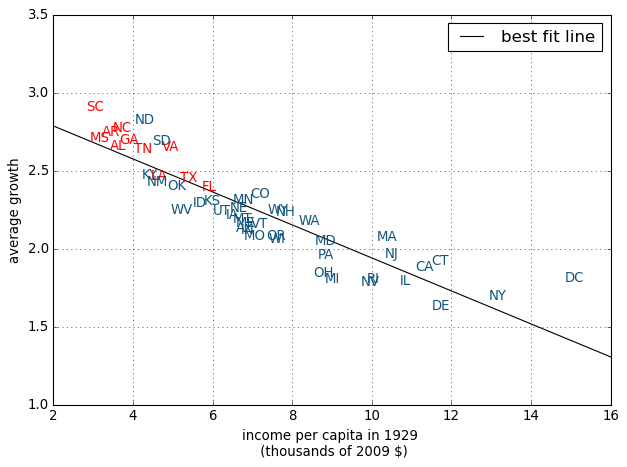

In [6]:
# 3.1 Plots

# 3. Plot the growth - initial income relationship
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(np.arange(0,20,0.001),inter+slope*np.arange(0,20,0.001),'-k',label='best fit line')
plt.legend(loc='upper right',fontsize='15')

for i,state in enumerate(state_income.columns):
    if state in csa:
        plt.text(origY[i], growth[i], state, color="red",fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)
    else:
        plt.text(origY[i], growth[i], state, color="#11557c",fontsize=12, clip_on=True,horizontalalignment='center',verticalalignment='center',alpha = 1)


ax.set_ylim([1,3.5])
ax.set_xlim([2,16])
ax.set_xlabel('income per capita in 1929 \n (thousands of 2009 $)')
ax.set_ylabel('average growth')
plt.grid()

plt.tight_layout()
plt.savefig('../png/fig_us_statesIncomeGrowth.png',bbox_inches='tight',dpi=120)

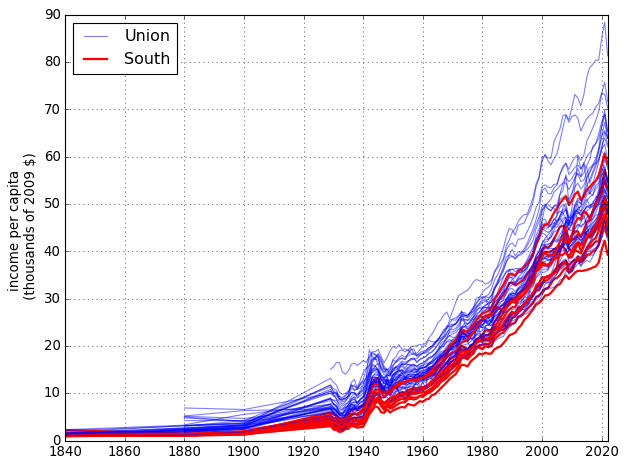

In [7]:
# 3.2 Plot income per capita in all states
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


for i,state in enumerate(state_income.columns):
    if state not in csa:
        north = ax.plot(state_income.index,state_income[state],'-b',lw=1,alpha=0.5,label='Union')

    else:
        south = ax.plot(state_income.index,state_income[state],'-r',lw=2,label='South')

ax.set_xlim([state_income.index[0],state_income.index[-1]])
# ax.locator_params(axis='x',nbins=5)
ax.set_ylabel('income per capita \n (thousands of 2009 $)')
# ax.locator_params(axis='x',nbins=6)
plt.grid()


lns = north+south
labs = [l.get_label() for l in lns]
plt.legend(lns,labs,loc='upper left')


plt.tight_layout()
plt.savefig('../png/fig_us_statesIncome.png',bbox_inches='tight',dpi=120)

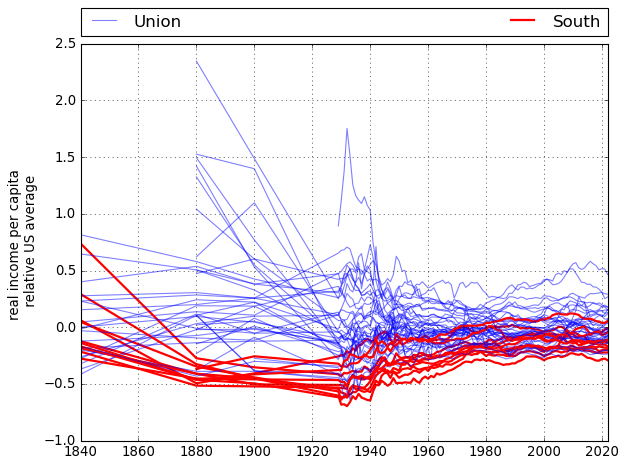

In [8]:
# 3.2 Plot income per capita in all states
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


for i,state in enumerate(state_income.columns):
    if state not in csa:
        north = ax.plot(state_income.index,(state_income[state]/usIncome-1),'-b',lw=1,alpha=0.5,label='Union')

    else:
        south = ax.plot(state_income.index,(state_income[state]/usIncome-1),'-r',lw=2,label='South')

ax.set_xlim([state_income.index[0],state_income.index[-1]])
# ax.locator_params(axis='x',nbins=5)
ax.set_ylabel('real income per capita \n relative US average')
# ax.locator_params(axis='x',nbins=6)
plt.grid()


lns = north+south
labs = [l.get_label() for l in lns]
plt.legend(lns,labs,bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
       ncol=3, mode="expand", borderaxespad=0.,fontsize=15)


plt.tight_layout()
plt.savefig('../png/fig_us_statesIncomeRelative.png',bbox_inches='tight',dpi=120)

In [9]:
# 4. Make the maps. Reference: http://flowingdata.com/2009/11/12/how-to-make-a-us-county-thematic-map-using-free-tools/

# 4.1.1 Specify a color scheme. Reference: http://colorbrewer2.org/
# colors=[,'#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']
colors=['#d4b9da','#c994c7','#df65b0','#e7298a','#ce1256','#980043','#67001f']
# colors=[#f1b6da','#fde0ef','#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221']
# colors.reverse()

# 4.1.2 Specify the ranges of deviations of income from the us average for the color scheme
bins = [-.25,-.15,-.05,.05,.15,.25]
# bins = [-.45,-.25,-.1,-.05-.025,.025,.05,.1,.25,.45]

In [10]:
# 4.2 Load svg with Beautiful Soup
soup = BeautifulSoup(svg, "lxml")
paths = soup.findAll('path')

/Users/bcjenkin/anaconda3/lib/python3.11/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [11]:
# 4.3 Create color-coded maps for each year

path_style = 'font-size:12px;fill-rule:nonzero;stroke:#FFFFFF;stroke-opacity:1;stroke-width:0.1;stroke-miterlimit:4;stroke-dasharray:none;stroke-linecap:butt;marker-start:none;stroke-linejoin:bevel;fill:'
states = state_income.columns.tolist()
years = state_income.index.tolist()

for t,year in enumerate(state_income.index):
    for p in paths:
        if p['id'] in states or p['id']=='MI-' or p['id']=='SP-':
            if p['id']=='MI-' or p['id']=='SP-':
                i = states.index('MI')
            else:
                i = states.index(p['id'])
            y = ((state_income[states[i]].iloc[t]-usIncome.iloc[t])/usIncome.iloc[t])

            if y<bins[0]:
                color_class = 6
            elif bins[0]<=y<bins[1]:
                color_class = 5
            elif bins[1]<=y<bins[2]:
                color_class = 4
            elif bins[2]<=y<bins[3]:
                color_class = 3
            elif bins[3]<=y<bins[4]:
                color_class = 2
            elif bins[4]<=y<bins[5]:
                color_class = 1
            else:
                color_class = 0

            if np.isnan(y):
                color = '#D3D3D3'
                print(states[i])
            else:
                color = colors[color_class]
                
            p['style'] = path_style + color

    svg = soup.prettify()[17:56]+u'1054'+soup.prettify()[59:-24]
    svg = svg+u'<text style="font-size:50px" id="tcol0" x="600" y="560">'+str(year.year)+u'</text>\n'

    svg = svg+u'<text style="font-size:20px" id="tcol0" x="875" y="225">'+'Income per capita'+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="875" y="250">'+'rel. to US avg.'+'</text>\n'
    
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="260" fill="'+colors[0]+'"/>\n'
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="300" fill="'+colors[1]+'"/>\n'
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="340" fill="'+colors[2]+'"/>\n'
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="380" fill="'+colors[3]+'"/>\n'
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="420" fill="'+colors[4]+'"/>\n'
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="460" fill="'+colors[5]+'"/>\n'
    svg = svg+u'<rect id="leg1" width="30" height="40" style="" x="875" y="500" fill="'+colors[6]+'"/>\n'

    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="290">above '+str(bins[5])+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="330">'+str(bins[4])+' to '+str(bins[5])+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="370">'+str(bins[3])+' to '+str(bins[4])+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="410">'+str(bins[2])+' to '+str(bins[3])+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="450">'+str(bins[1])+' to '+str(bins[2])+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="490">'+str(bins[0])+' to '+str(bins[1])+'</text>\n'
    svg = svg+u'<text style="font-size:20px" id="tcol0" x="915" y="530"> below '+str(bins[0])+'</text>\n'
    
    svg = svg+soup.prettify()[-24:-17]
    
    svg = svg.split('<body>')[1]
    
    head = '<?xml version="1.0" encoding="UTF-8" standalone="no"?>\n<?xml-stylesheet href="Blank_US_Map.css" type="text/css"?>'
    svg = head + svg
    svg = svg.replace('width="959"','width="1035"')
    
    
    with open("../frames/state_relative_income"+str(year.year)+".svg", "wb") as file:
        file.write(bytes(svg, 'UTF-8'))

    file = open("../frames/state_relative_income"+str(year.year)+".svg", "a")
    convert = 'convert -density 144 ../frames/state_relative_income'+str(year.year)+'.svg ../frames/state_relative_income'+str(year.year)+'.png'
    subprocess.call(convert,shell=True)

DC
MN
OK
TX
NM
KS
NE
SD
ND
WY
MT
CO
ID
UT
AZ
NV
OR
WA
CA
DC
OK
DC


In [12]:
# 4.4 Creat gif with imagemagick
makegif = 'convert -loop 0 -delay 50x100 ../frames/*.png ../gif/us_state_convergence.gif'
subprocess.call(makegif,shell=True)

0

In [13]:
# 5. Clean up
# os.chdir(os.getcwd())
# for files in os.listdir('.'):
#     if files.endswith('.css') or files.endswith('.svg'):
#         os.remove(files)